<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_preliminaries/2_derivatives_plots_automatic_differentiation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## numerical limit

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

In [3]:
def f(x):
    return 3 * x ** 2 - 4 * x

In [6]:
for h in 10.0**np.arange(-1, -6, -1):
    print(f'h={h:.5f} - numerical limit of f(x) at x=1:{(f(1+h)-f(1))/h:.5f}')

h=0.10000 - numerical limit of f(x) at x=1:2.30000
h=0.01000 - numerical limit of f(x) at x=1:2.03000
h=0.00100 - numerical limit of f(x) at x=1:2.00300
h=0.00010 - numerical limit of f(x) at x=1:2.00030
h=0.00001 - numerical limit of f(x) at x=1:2.00003


## plotting functions, the beautiful way

### easy way

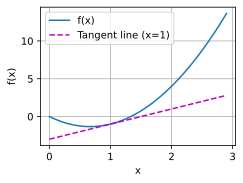

In [78]:
backend_inline.set_matplotlib_formats('svg')  # svg has more resolution and sharper
x = np.arange(0, 3, 0.1)
plt.plot(x, f(x), label='f(x)')
plt.plot(x, 2 * x - 3, 'm--', label='Tangent line (x=1)')
plt.xlabel('x'), plt.ylabel('f(x)')
plt.grid() 
plt.legend()

### harder d2l way


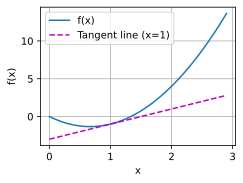

In [82]:
def use_svg_disply():
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_disply()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """This function is designed to handle the following cases:
    - X = [1, 3, 5, 8], Y = None -> plots X is f it was Y, and places [1, 2, 3, 4] for X.
    - X = np.array([1, 1.5, 2]), Y = same.
    - last case is what is being plot here.
    So basically, either give only X and plot on integers, or provide the X values,
    and plot one of the same size, or multiple on the same figure."""
    def has_one_axis(X):  # True if X (tensor or list) has one axis
        return (hasattr(X, 'ndim') and X.ndim==1 or isinstance(X, list)
                and not hasattr(X[0], '__len__'))
    
    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    
    set_figsize(figsize)
    if axes is None:
        axes = plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt) if len(x) else axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', ['f(x)', 'Tangent line (x=1)'])

### Some 3d plots

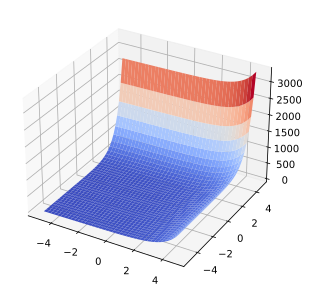

In [89]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection='3d')
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = 6 * X + 5 * np.exp(X) + 5 * Y * np.exp(Y)
ax.plot_surface(X, Y, R, cmap=cm.coolwarm)


## Automatic differentiation

In [118]:
import torch

x = torch.arange(4.0, requires_grad=True)  # .0 because only float type can require grad
# or do x.requires_grad_(True)  # _ is needed because here in this example x it is a leaf node
(x, x.grad)  # initializes to None by default

(tensor([0., 1., 2., 3.], requires_grad=True), None)

In [119]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [120]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [121]:
x.grad == 4 * x

tensor([True, True, True, True])

In [124]:
x.grad.zero_()  # by defult, the gradient is added to the gradient buffer. The
                # default behaviour is useful when the gradient of a sum of losses
                # is computed.
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### non-scalar objectives
Here the jacobian needs to be used. different frameworks handle non-scalar differently. Essentialy, one has to reduce the result to a scalar.

In [126]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # This is faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### Detaching Computation
if a variable is detached, its _provenance_ is wiped out meaning it does not have an ancestor in the computational graph, hence backprop does not pass through it.

In [129]:
# Consider a case where you want some variable as intermediate representations
# of the input, but you don't want to be considered in gradient computations.
# consider z = x * y and y = x * x, but y should not contribute to gradient and
# you only want z wrt x and not y. you detach it from computation graph.
x.grad.zero_()
y = x * x
u = y.detach()
z = x * u
z.sum().backward()
x.grad == u  # equals to u as expected

tensor([True, True, True, True])

In [132]:
# note that whole u is detached from computation graph, y is still attached and
# we can compute gradient of y wrt x
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

### Gradients and Python Control Flow


In [133]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)  # Note that we are differentiating
# wrt a, which goes through a series of python control flow - for loop and if conditions
d = f(a)
d.backward()  # probably here the computation graph is already known by the compiler
              # ??? but does it have to rebuild the computation graph each time
              # a changes. probably yes.
a.grad == d/a  # ??? How?

tensor(True)

# Exercises

## 2
After running the function for backpropagation, immediately run it again and see what happens. Why?

In [43]:
import torch

x = torch.tensor([0.0, 1, 2, 3], requires_grad=True)
y = 2 * x

In [36]:
y.sum().backward()
y.sum().backward()
x.grad

RuntimeError: ignored

In [44]:
y.sum().backward(retain_graph=True)
y.sum().backward()
x.grad

tensor([4., 4., 4., 4.])

## 4
Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result.

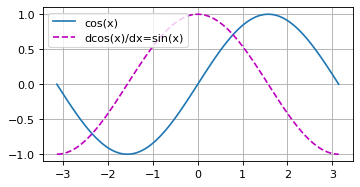

In [10]:
import torch

x = torch.linspace(-torch.pi, torch.pi, 100)
x.requires_grad_(True)

def f(x):
    return torch.sin(x)

y = f(x)
y.sum().backward()

import matplotlib.pyplot as plt
# from matplotlib_inline import backend_inline
# backend_inline.set_matplotlib_formats('svg')
plt.figure(figsize=(5, 2.5), dpi=80)
# plt.rcParams['figure.figsize'] = (5, 2.5)



plt.plot(x.detach().numpy(), f(x).detach().numpy(), '-', label='cos(x)')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), 'm--', label='dcos(x)/dx=sin(x)')
plt.grid()
legend = plt.legend()

## 5
Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$. 

In [46]:
x = torch.arange(10.0, requires_grad=True)
invx = 1/x
logx2 = torch.log(x**2)
sinx = torch.sin(x)
y = logx2 * sinx + invx

print('y=', y)

y= tensor([    nan,  1.0000,  1.7606,  0.6434, -1.8483, -2.8867, -0.8346,  2.6997,
         4.2396,  1.9221], grad_fn=<AddBackward0>)
